In [1]:
# Import library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load, dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Paths
WORKDIR = r"d:\Project Akhir PSD"
ARTIFACT_DATA = os.path.join(WORKDIR, 'data_processed.npz')
ARTIFACT_PIPELINE = os.path.join(WORKDIR, 'preprocessing_pipeline.joblib')
LABEL_ENCODER_PATH = os.path.join(WORKDIR, 'label_encoder.joblib')
MODEL_PIPELINE_PATH = os.path.join(WORKDIR, 'model_pipeline.joblib')
FIG_DIR = os.path.join(WORKDIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

print('Working dir:', WORKDIR)
print('Artifacts:', ARTIFACT_DATA, ARTIFACT_PIPELINE)

Working dir: d:\Project Akhir PSD
Artifacts: d:\Project Akhir PSD\data_processed.npz d:\Project Akhir PSD\preprocessing_pipeline.joblib


## 1. Muat hasil preprocessing

In [2]:
# Muat arrays processed
data = np.load(ARTIFACT_DATA, allow_pickle=True)
X_train = data['X_train']
X_test  = data['X_test']
y_train = data['y_train']
y_test  = data['y_test']
label_classes = data['label_classes']

# Muat preprocessing pipeline dan label encoder
preproc = load(ARTIFACT_PIPELINE)
le = load(LABEL_ENCODER_PATH)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)
print('Label classes:', label_classes)

X_train shape: (130, 14773)
X_test shape:  (33, 14773)
Label classes: ['cat' 'dog']


## 2. Cross-validation pada data train (setelah transformasi)

Karena pipeline preprocessing sudah fit pada tahap preprocessing, kita transform data train lalu lakukan CV pada fitur tertransformasi.

In [5]:
# Transform fitur dengan preproc
X_train_t = preproc.transform(X_train)
X_test_t  = preproc.transform(X_test)

# Definisikan classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train_t, y_train, cv=cv, scoring='f1_macro')
print('CV F1-macro (mean ± std):', scores.mean(), scores.std())

# Simpan CV results ke file sederhana
with open(os.path.join(WORKDIR, 'cv_results.txt'), 'w') as f:
    f.write(f'CV F1 macro scores: {scores.tolist()}\nMean: {scores.mean():.4f}, Std: {scores.std():.4f}\n')

print('CV results saved to cv_results.txt')

CV F1-macro (mean ± std): 0.5196212333393742 0.09557827175241908
CV results saved to cv_results.txt


## 3. Latih model final dan evaluasi pada test set

Test Accuracy: 0.696969696969697
Test F1-macro: 0.6966911764705883

Classification Report:
              precision    recall  f1-score   support

         cat       0.71      0.71      0.71        17
         dog       0.69      0.69      0.69        16

    accuracy                           0.70        33
   macro avg       0.70      0.70      0.70        33
weighted avg       0.70      0.70      0.70        33



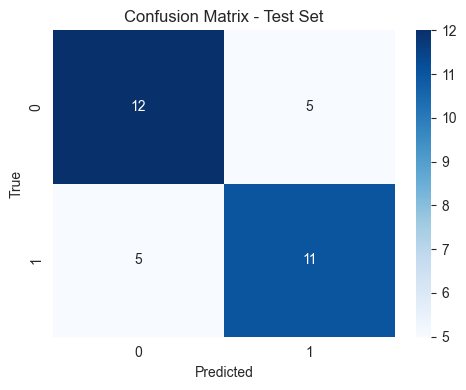

Test metrics saved to test_metrics.txt


In [ ]:
# Latih classifier pada data train tertransformasi
clf.fit(X_train_t, y_train)

# Prediksi pada test set
y_pred = clf.predict(X_test_t)

        {
            "cell_type": "code",
            "id": "#VSC-e2f1b873",
            "metadata": {
                "language": "python"
            },
            "source": [
                "# Cross-validation yang benar: letakkan preprocessing di dalam Pipeline",
                "# sehingga setiap fold hanya melihat data train-nya saat fitting preprocessing",
                "pipeline = Pipeline([",
                "    ('preproc', preproc),",
                "    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))",
                "])",
                "",
                "# Stratified K-Fold CV pada data mentah (X_train), bukan pada fitur yang sudah ditransform",
                "cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)",
                "scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)",
                "print('Pipeline CV F1-macro (mean ± std):', scores.mean(), scores.std())",
                "",
                "# Simpan hasil CV ke file terpisah agar tidak menimpa hasil sebelumnya",
                "with open(os.path.join(WORKDIR, 'cv_results_pipeline.txt'), 'w') as f:",
                "    f.write(f'Pipeline CV F1 macro scores: {scores.tolist()}\\nMean: {scores.mean():.4f}, Std: {scores.std():.4f}\\n')",
                "",
                "print('Pipeline CV results saved to cv_results_pipeline.txt')"
            ]
        },
<VSCode.Cell id="#VSC-aac27156" language="markdown">
## 4. Simpan model gabungan (preprocessing + classifier)

Menyimpan `Pipeline` yang menggabungkan preprocessing dan classifier mempermudah deployment.

In [ ]:
# Gabungkan preproc (yang sudah fit) + classifier
model_pipeline = Pipeline([('preproc', preproc), ('clf', clf)])
# Simpan
dump(model_pipeline, MODEL_PIPELINE_PATH)
print('Model pipeline tersimpan di:', MODEL_PIPELINE_PATH)

Mulai RandomizedSearchCV (ini bisa beberapa menit) ...
RandomizedSearchCV selesai dalam 115.7s
Best CV score: 0.5877267917267917
Best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 40}
Best pipeline tersimpan di: d:\Project Akhir PSD\model_pipeline.joblib
Test Accuracy (best): 0.5757575757575758
Test F1-macro (best): 0.5753676470588236


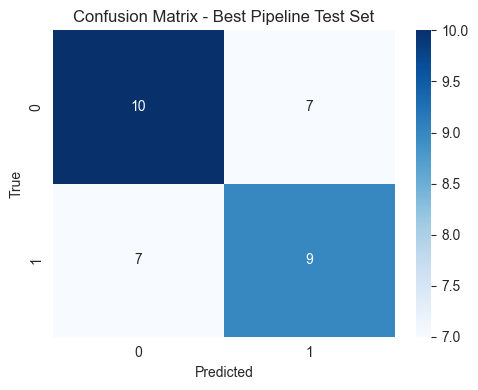

Random search results and test metrics disimpan di direktori kerja.


In [6]:
# Pipeline dengan PCA + RandomizedSearchCV untuk tuning cepat
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import time

pipeline = Pipeline([
    ('var', VarianceThreshold(threshold=1e-5)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('clf', RandomForestClassifier(random_state=42))
])

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 10, 20, 40],
    'clf__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'clf__min_samples_split': [2, 5, 10],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=30, cv=cv, scoring='f1_macro', random_state=42, n_jobs=-1)

print('Mulai RandomizedSearchCV (ini bisa beberapa menit) ...')
t0 = time.time()
rs.fit(X_train, y_train)
t1 = time.time()
print(f'RandomizedSearchCV selesai dalam {t1-t0:.1f}s')
print('Best CV score:', rs.best_score_)
print('Best params:', rs.best_params_)

# Simpan estimator terbaik sebagai model pipeline
best_pipeline = rs.best_estimator_
dump(best_pipeline, MODEL_PIPELINE_PATH)
print('Best pipeline tersimpan di:', MODEL_PIPELINE_PATH)

# Evaluasi singkat pada test set
y_pred_best = best_pipeline.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='macro')
print('Test Accuracy (best):', acc_best)
print('Test F1-macro (best):', f1_best)

# Simpan metrik dan hasil pencarian
with open(os.path.join(WORKDIR, 'random_search_results.txt'), 'w') as f:
    f.write(f'Best score: {rs.best_score_}\nBest params: {rs.best_params_}\nElapsed: {t1-t0:.1f}s\n')
with open(os.path.join(WORKDIR, 'test_metrics_best_pipeline.txt'), 'w') as f:
    f.write(f'Accuracy: {acc_best:.4f}\nF1_macro: {f1_best:.4f}\n')

# Confusion matrix untuk pipeline terbaik
cm = confusion_matrix(y_test, y_pred_best)
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix - Best Pipeline Test Set')
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, 'confusion_matrix_best_pipeline.png'))
plt.show()

print('Random search results and test metrics disimpan di direktori kerja.')

Mulai RandomizedSearchCV untuk LightGBM (bisa butuh beberapa menit) ...
[LightGBM] [Info] Number of positive: 65, number of negative: 65
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3460
[LightGBM] [Info] Number of data points in the train set: 130, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


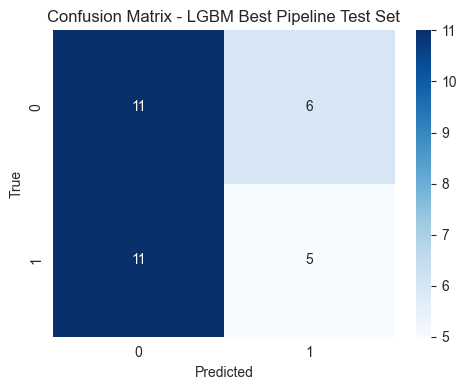

LGBM tidak lebih baik dari pipeline sebelumnya; model tidak ditimpa.


In [3]:
# Eksperimen: LightGBM + PCA + RandomizedSearchCV
# Tujuan: coba model alternatif yang sering bekerja lebih baik pada fitur banyak
try:
    import lightgbm as lgb
except Exception as e:
    raise ImportError('lightgbm tidak terpasang di environment. Pasang dengan pip install lightgbm lalu jalankan ulang.')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
import time

pipeline_lgb = Pipeline([
    ('var', VarianceThreshold(threshold=1e-5)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('clf', lgb.LGBMClassifier(random_state=42))
])

param_dist_lgb = {
    'clf__n_estimators': [100, 200, 400],
    'clf__num_leaves': [15, 31, 63],
    'clf__max_depth': [-1, 10, 20, 40],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs_lgb = RandomizedSearchCV(pipeline_lgb, param_distributions=param_dist_lgb, n_iter=30, cv=cv, scoring='f1_macro', random_state=42, n_jobs=-1)

print('Mulai RandomizedSearchCV untuk LightGBM (bisa butuh beberapa menit) ...')
start = time.time()
rs_lgb.fit(X_train, y_train)
end = time.time()
print(f'RandomizedSearchCV LGBM selesai dalam {end-start:.1f}s')
print('Best CV score (LGBM):', rs_lgb.best_score_)
print('Best params (LGBM):', rs_lgb.best_params_)

# Simpan jika performa lebih baik dibandingkan pipeline sebelumnya (cek file random_search_results.txt sebelumnya)
best_lgb_pipeline = rs_lgb.best_estimator_

# Simpan hasil Pencarian dan model
with open(os.path.join(WORKDIR, 'random_search_lgbm_results.txt'), 'w') as f:
    f.write(f'Best score: {rs_lgb.best_score_}\nBest params: {rs_lgb.best_params_}\nElapsed: {end-start:.1f}s\n')

# Evaluasi pada test set
y_pred_lgb = best_lgb_pipeline.predict(X_test)
acc_lgb = accuracy_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb, average='macro')
print('Test Accuracy (LGBM best):', acc_lgb)
print('Test F1-macro (LGBM best):', f1_lgb)

with open(os.path.join(WORKDIR, 'test_metrics_lgbm.txt'), 'w') as f:
    f.write(f'Accuracy: {acc_lgb:.4f}\nF1_macro: {f1_lgb:.4f}\n')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix - LGBM Best Pipeline Test Set')
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, 'confusion_matrix_lgbm_best.png'))
plt.show()

# Bandingkan dengan hasil sebelumnya (jika ada). Jika LGBM lebih baik pada CV atau test, simpan sebagai model utama
save_model = False
try:
    # baca best CV skor dari random_search_results.txt jika ada
    prev_path = os.path.join(WORKDIR, 'random_search_results.txt')
    if os.path.exists(prev_path):
        with open(prev_path, 'r') as f:
            prev = f.read()
        # cari pattern 'Best score:' atau hanya parse float dari file
        if 'Best score' in prev:
            # ekstrak angka
            import re
            m = re.search(r'Best score:\s*([0-9\.]+)', prev)
            if m:
                prev_score = float(m.group(1))
                if rs_lgb.best_score_ >= prev_score:
                    save_model = True
    else:
        # jika tidak ada file pembanding, simpan model LGBM
        save_model = True
except Exception:
    save_model = True

if save_model:
    dump(best_lgb_pipeline, MODEL_PIPELINE_PATH)
    print('Model pipeline LGBM tersimpan di:', MODEL_PIPELINE_PATH)
else:
    print('LGBM tidak lebih baik dari pipeline sebelumnya; model tidak ditimpa.')

Mulai RandomizedSearchCV dengan SelectKBest (k=200)...
Selesai dalam 26.1s
Best CV score (SelectKBest): 0.5750323750323749
Best params (SelectKBest): {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__max_features': 'log2', 'clf__max_depth': None}
Test Accuracy (SelectKBest best): 0.6363636363636364
Test F1-macro (SelectKBest best): 0.6360294117647058


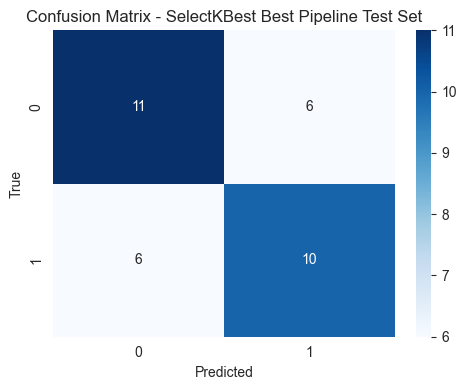

Best SelectKBest pipeline tersimpan di: d:\Project Akhir PSD\model_pipeline_selectk.joblib


In [4]:
# SelectKBest(k=200) + RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
import time

k = 200
pipeline_sk = Pipeline([
    ('var', VarianceThreshold(threshold=1e-5)),
    ('scaler', StandardScaler()),
    ('skb', SelectKBest(score_func=f_classif, k=k)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_dist_sk = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 10, 20, 40],
    'clf__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'clf__min_samples_split': [2, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs_sk = RandomizedSearchCV(pipeline_sk, param_distributions=param_dist_sk, n_iter=30, cv=cv, scoring='f1_macro', random_state=42, n_jobs=-1)

print(f'Mulai RandomizedSearchCV dengan SelectKBest (k={k})...')
t0 = time.time()
rs_sk.fit(X_train, y_train)
t1 = time.time()
print(f'Selesai dalam {t1-t0:.1f}s')
print('Best CV score (SelectKBest):', rs_sk.best_score_)
print('Best params (SelectKBest):', rs_sk.best_params_)

best_sk = rs_sk.best_estimator_

# Simpan hasil pencarian
with open(os.path.join(WORKDIR, 'random_search_selectk_results.txt'), 'w') as f:
    f.write(f'Best score: {rs_sk.best_score_}\nBest params: {rs_sk.best_params_}\nElapsed: {t1-t0:.1f}s\n')

# Evaluasi pada test set
y_pred_sk = best_sk.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred_sk)
f1_sk = f1_score(y_test, y_pred_sk, average='macro')
print('Test Accuracy (SelectKBest best):', acc_sk)
print('Test F1-macro (SelectKBest best):', f1_sk)

with open(os.path.join(WORKDIR, 'test_metrics_selectk.txt'), 'w') as f:
    f.write(f'Accuracy: {acc_sk:.4f}\nF1_macro: {f1_sk:.4f}\n')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_sk)
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix - SelectKBest Best Pipeline Test Set')
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, 'confusion_matrix_selectk_best.png'))
plt.show()

# Simpan model terbaik SelectKBest
MODEL_PIPELINE_SELECTK_PATH = os.path.join(WORKDIR, 'model_pipeline_selectk.joblib')
dump(best_sk, MODEL_PIPELINE_SELECTK_PATH)
print('Best SelectKBest pipeline tersimpan di:', MODEL_PIPELINE_SELECTK_PATH)

In [5]:
# Nested CV untuk estimasi performa yang lebih andal
# Outer CV: StratifiedKFold(5) ; Inner: RandomizedSearchCV (n_iter=10)
from sklearn.model_selection import cross_val_score
import time

pipeline_nested = Pipeline([
    ('var', VarianceThreshold(threshold=1e-5)),
    ('scaler', StandardScaler()),
    ('skb', SelectKBest(score_func=f_classif, k=200)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_dist_nested = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 10, 20, 40],
    'clf__max_features': ['sqrt', 'log2', 0.2],
    'clf__min_samples_split': [2, 5]
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs_inner = RandomizedSearchCV(pipeline_nested, param_distributions=param_dist_nested, n_iter=10, cv=inner_cv, scoring='f1_macro', random_state=42, n_jobs=-1)

print('Mulai nested CV (outer 5-fold, inner RandomizedSearch n_iter=10) ...')
start = time.time()
nested_scores = cross_val_score(rs_inner, X_train, y_train, cv=outer_cv, scoring='f1_macro', n_jobs=-1)
end = time.time()
print(f'Nested CV selesai dalam {end-start:.1f}s')
print('Nested CV F1-macro scores:', nested_scores)
print('Nested CV mean ± std:', nested_scores.mean(), nested_scores.std())

# Simpan hasil
with open(os.path.join(WORKDIR, 'nested_cv_results.txt'), 'w') as f:
    f.write(f'Nested CV scores: {nested_scores.tolist()}\nMean: {nested_scores.mean():.4f}, Std: {nested_scores.std():.4f}\nElapsed: {end-start:.1f}s\n')

print('Hasil nested CV disimpan di nested_cv_results.txt')

Mulai nested CV (outer 5-fold, inner RandomizedSearch n_iter=10) ...
Nested CV selesai dalam 18.3s
Nested CV F1-macro scores: [0.57121439 0.53571429 0.41529235 0.52727273 0.5762963 ]
Nested CV mean ± std: 0.5251580111819992 0.0581767721957079
Hasil nested CV disimpan di nested_cv_results.txt


In [7]:
# Simpan model pipeline SelectKBest sebagai model_pipeline.joblib dan lakukan smoke test
from joblib import load, dump
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

src = os.path.join(WORKDIR, 'model_pipeline_selectk.joblib')
dst = MODEL_PIPELINE_PATH

if os.path.exists(src):
    print('Menyalin', src, '->', dst)
    m = load(src)
    dump(m, dst)
    print('Model tersalin.')
else:
    print('Model sumber tidak ditemukan:', src)

# Smoke test: muat model yang baru dan lakukan prediksi pada X_test
if os.path.exists(dst):
    model = load(dst)
    try:
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        print('Smoke test - Accuracy:', acc)
        print('Smoke test - F1-macro:', f1)
        with open(os.path.join(WORKDIR, 'test_metrics_deploy.txt'), 'w') as f:
            f.write(f'Accuracy: {acc:.4f}\nF1_macro: {f1:.4f}\n')
        print('Smoke test metrics saved to test_metrics_deploy.txt')
    except Exception as e:
        print('Gagal melakukan prediksi pada X_test:', str(e))
else:
    print('Model tujuan tidak ditemukan, tidak ada smoke test.')

Menyalin d:\Project Akhir PSD\model_pipeline_selectk.joblib -> d:\Project Akhir PSD\model_pipeline.joblib
Model tersalin.
Smoke test - Accuracy: 0.6363636363636364
Smoke test - F1-macro: 0.6360294117647058
Smoke test metrics saved to test_metrics_deploy.txt


## 5. Catatan dan langkah selanjutnya

- Model default: RandomForest (cukup baik untuk baseline). Untuk peningkatan, coba SVM, LightGBM, atau 1D-CNN (untuk raw time-series).
- Simpan juga beberapa contoh prediksi untuk ditampilkan di demo Streamlit.